# 7.3らへん

In [40]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import japanize_matplotlib

In [41]:
# トイデータ生成
N = 20
x_data = np.random.uniform(-1, 1, N)

def true_func(x):
    return 2*np.exp(x) * np.sin(2*np.pi * x)

y_data = true_func(x_data) - 0.2 + np.random.randn(N)

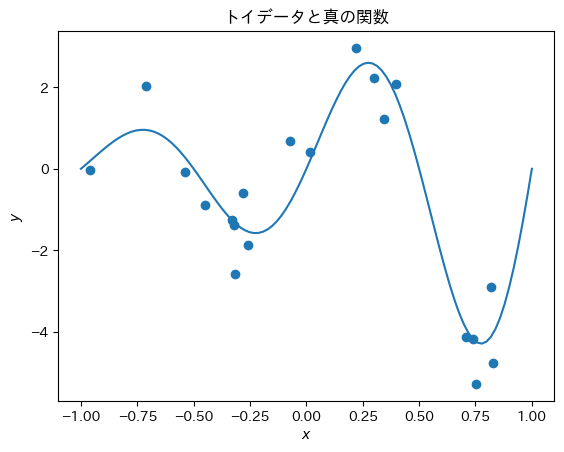

In [42]:
plt.scatter(x_data, y_data)
tmp = np.linspace(-1,1,100)
plt.plot(tmp, true_func(tmp))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("トイデータと真の関数");

In [43]:
x_data = jnp.array(x_data)
y_data = jnp.array(y_data)

## 普通のガウス過程

In [44]:
# RBFカーネル
def rbf_kernel(scale, x, x_p):
    return jnp.exp(-(jnp.linalg.norm(x-x_p)**2)/scale)

In [45]:
def make_K(datas, sigma, scale):
    matK = jnp.zeros((len(datas), len(datas)))
    for x_idx, xd in enumerate(datas):
        for xp_idx, xpd in enumerate(datas):
            if(x_idx == xp_idx):
                matK = matK.at[x_idx, xp_idx].set(sigma + rbf_kernel(scale, xd, xpd))
            else:
                matK = matK.at[x_idx, xp_idx].set(rbf_kernel(scale, xd, xpd))
    return matK

def make_k_vec(datas, x, scale):
    k_vec = jnp.zeros(len(datas))
    for idx, d in enumerate(datas):
        k_vec = k_vec.at[idx].set(rbf_kernel(scale, d, x))
    return k_vec

In [46]:
scale = 0.01
sigma = 1

K_inv = jnp.linalg.inv(make_K(x_data, sigma, scale))

In [47]:
x_pred = jnp.linspace(-1, 1, 100)
y_pred = jnp.zeros(len(x_pred))
y_std = jnp.zeros(len(x_pred))

In [48]:
for n, x_p in enumerate(x_pred):
    k_vec = make_k_vec(x_data, x_p, scale)
    tmp = k_vec @ K_inv
    pred = tmp @ y_data.T
    var = rbf_kernel(scale, x_p, x_p) - tmp @ k_vec.T
    y_pred = y_pred.at[n].set(pred)
    y_std = y_std.at[n].set(jnp.sqrt(var))


Text(0.5, 1.0, '普通のガウス過程回帰')

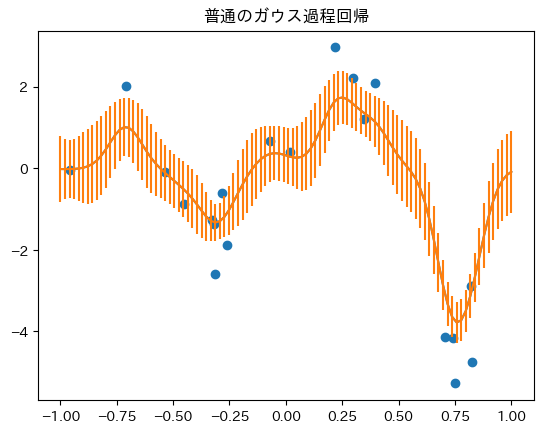

In [49]:
plt.plot(x_pred, y_pred)
plt.errorbar(x_pred, y_pred, y_std)
plt.scatter(x_data, y_data)
# tmp = np.linspace(-1,1,100)
# plt.plot(tmp, true_func(tmp))
plt.title("普通のガウス過程回帰")

## 誘導点法

In [50]:
M = 5
ips = np.random.uniform(-1, 1, M)
ips = jnp.array(ips)

In [51]:
def make_Kxz(xdatas, zdatas, scale):
    matKxz = jnp.zeros((len(xdatas), len(zdatas)))
    for x_idx, xd in enumerate(xdatas):
        for z_idx, zd in enumerate(zdatas):
            matKxz = matKxz.at[x_idx, z_idx].set(rbf_kernel(scale, xd, zd))
    return matKxz

In [52]:
K_zz = make_Kxz(ips, ips, scale)
K_xz = make_Kxz(x_data, ips, scale)

In [53]:
x_pred = jnp.linspace(-1, 1, 100)
y_pred = jnp.zeros(len(x_pred))
y_std = jnp.zeros(len(x_pred))

for n, x_p in enumerate(x_pred):
    k_vec = make_k_vec(ips, x_p, scale)
    tmp = jnp.linalg.inv(K_zz + (1/sigma) * K_xz.T @ K_xz)
    mu = k_vec.T @ ((1/sigma) * tmp @ K_xz.T @ y_data.T)
    Kzz_inv = jnp.linalg.inv(make_Kxz(ips, ips, scale))
    var = rbf_kernel(scale, x_p, x_p) - k_vec.T @ Kzz_inv @ k_vec + k_vec.T @ tmp @ k_vec.T 
    y_pred = y_pred.at[n].set(mu)
    y_std = y_std.at[n].set(jnp.sqrt(var))
    

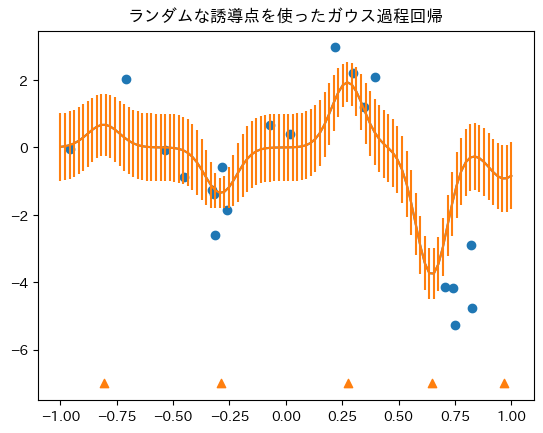

In [54]:
plt.plot(x_pred, y_pred)
plt.scatter(x_data, y_data)
plt.errorbar(x_pred, y_pred, y_std)
plt.scatter(ips, [-7]*len(ips), marker="^")
plt.title("ランダムな誘導点を使ったガウス過程回帰");